In [ ]:
#!pip install keras
#!pip install -U scikit-learn
#!pip install pillow
#!pip install matplotlib
#!pip install jupyternotify
%load_ext jupyternotify

## Variables Being Used

In [8]:
batch_size=16
#val_split=0.2 #20 percent validation
image_size=256
image_shape=(image_size,image_size)
train_file_directory='/root/DR_noDR/Training'
validation_file_directory='/root/DR_noDR/Validation'
alt_train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training_no_weights'

In [9]:
!nvidia-smi

Wed Apr 12 15:40:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8    33W / 420W |      1MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Datasets

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.applications.resnet_v2 import preprocess_input

training_datagen = ImageDataGenerator( 
        preprocessing_function=preprocess_input, # use this only when using VGG16
        #rescale=1./255,
        rotation_range=45,
        shear_range=5,
        zoom_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        )

validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./255    
        )

#Creating our generators, no need of changing values here
train_generator = training_datagen.flow_from_directory( #Creating our training generator 
        train_file_directory,  
        target_size=image_shape,
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = True,
        )
train_generator_validation = training_datagen.flow_from_directory( #Creating our training generator 
        train_file_directory,  
        target_size=image_shape,
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
        )
validation_generator = validation_datagen.flow_from_directory( #Creating our validation generator
        validation_file_directory, 
        target_size=image_shape, 
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
)

Found 561 images belonging to 2 classes.
Found 561 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [11]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Displaying Images

In [ ]:
# Enable/Disable to see 4 random images
fig, axs=plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    axs[i].imshow(train_generator[i][0][0],cmap='gray',vmin=0,vmax=255)

## Creating weights

In [12]:
import numpy as np ## Calculating the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weighing = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights=dict(zip(np.unique(train_generator.classes), class_weighing))

print(class_weights)

{0: 0.9077669902912622, 1: 1.1130952380952381}


## Creating Model

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D,BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
import keras

In [15]:
base_model = keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

base_model.trainable = False
inputs = keras.Input(shape=(image_size, image_size, 3))

#for layer in base_model.layers[:15]:
#   layer.trainable = False
#for layer in base_model.layers[15:]:
#   layer.trainable = True

x = base_model(inputs)
#x=keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same")(x)
#x=BatchNormalization()(x)
#x=keras.layers.Activation("relu")(x)
#x=keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same")(x)
#x=BatchNormalization()(x)
#x=keras.layers.Activation("relu")(x)
#x=keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x=BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x=Dropout(0.4)(x)

x=keras.layers.Dense(750,kernel_regularizer=regularizers.l2(0.01))(x)#,kernel_regularizer=regularizer.l2(0.01))(x)
x=BatchNormalization()(x)
x=keras.layers.Activation("relu")(x)
x=Dropout(0.4)(x)
x=keras.layers.Dense(500,kernel_regularizer=regularizers.l2(0.01))(x)
x=BatchNormalization()(x)
x=keras.layers.Activation("relu")(x)
x=Dropout(0.4)(x)
x=keras.layers.Dense(250,kernel_regularizer=regularizers.l2(0.01))(x)
x=BatchNormalization()(x)
x=keras.layers.Activation("relu")(x)
x=Dropout(0.4)(x)
outputs = keras.layers.Dense(2,activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary(expand_nested=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_3 (InputLayer)      [(None, 256, 256, 3)]     0         |
|                                                               |
| conv1_pad (ZeroPadding2D)  (None, 262, 262, 3)      0         |
|                                                               |
| conv1_conv (Conv2D)       (None, 128, 128, 64)      9472      |
|                                                               |
| pool1_pad (ZeroPadding2D)  (None, 130, 130, 64)     0         |
|                                                               |
| pool1_pool (MaxPooling2D)  (None, 64, 64, 64)       0    

|                                                               |
| conv3_block1_1_conv (Conv2D  (None, 32, 32, 128)    32768     |
| )                                                             |
|                                                               |
| conv3_block1_1_bn (BatchNor  (None, 32, 32, 128)    512       |
| malization)                                                   |
|                                                               |
| conv3_block1_1_relu (Activa  (None, 32, 32, 128)    0         |
| tion)                                                         |
|                                                               |
| conv3_block1_2_pad (ZeroPad  (None, 34, 34, 128)    0         |
| ding2D)                                                       |
|                                                               |
| conv3_block1_2_conv (Conv2D  (None, 32, 32, 128)    147456    |
| )                                                             |
|         

| )                                                             |
|                                                               |
| conv3_block4_out (Add)    (None, 16, 16, 512)       0         |
|                                                               |
| conv4_block1_preact_bn (Bat  (None, 16, 16, 512)    2048      |
| chNormalization)                                              |
|                                                               |
| conv4_block1_preact_relu (A  (None, 16, 16, 512)    0         |
| ctivation)                                                    |
|                                                               |
| conv4_block1_1_conv (Conv2D  (None, 16, 16, 256)    131072    |
| )                                                             |
|                                                               |
| conv4_block1_1_bn (BatchNor  (None, 16, 16, 256)    1024      |
| malization)                                                   |
|         

| malization)                                                   |
|                                                               |
| conv4_block4_2_relu (Activa  (None, 16, 16, 256)    0         |
| tion)                                                         |
|                                                               |
| conv4_block4_3_conv (Conv2D  (None, 16, 16, 1024)   263168    |
| )                                                             |
|                                                               |
| conv4_block4_out (Add)    (None, 16, 16, 1024)      0         |
|                                                               |
| conv4_block5_preact_bn (Bat  (None, 16, 16, 1024)   4096      |
| chNormalization)                                              |
|                                                               |
| conv4_block5_preact_relu (A  (None, 16, 16, 1024)   0         |
| ctivation)                                                    |
|         

| tion)                                                         |
|                                                               |
| conv5_block2_2_pad (ZeroPad  (None, 10, 10, 512)    0         |
| ding2D)                                                       |
|                                                               |
| conv5_block2_2_conv (Conv2D  (None, 8, 8, 512)      2359296   |
| )                                                             |
|                                                               |
| conv5_block2_2_bn (BatchNor  (None, 8, 8, 512)      2048      |
| malization)                                                   |
|                                                               |
| conv5_block2_2_relu (Activa  (None, 8, 8, 512)      0         |
| tion)                                                         |
|                                                               |
| conv5_block2_3_conv (Conv2D  (None, 8, 8, 2048)     1050624   |
| )       

### Compile

In [30]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), #SGD or adam
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

### Generating Callbacks

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="/root/DR-detection-using-OCT-A/saved_models/Resnet50v2_binary_{val_accuracy:.2f}_{epoch:02d}.hdf5"

checkpoint= ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
early_stop=EarlyStopping(monitor='accuracy',patience=150,verbose=0) #only change patience

callback_list=[checkpoint,early_stop]#add the callbacks used

### Model.Fit()

In [32]:
%%notify
history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//batch_size,
        verbose=1, 
        epochs=75,  #change this
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//batch_size,
        callbacks=callback_list,
        class_weight=class_weights
)
print("Done bro")

Epoch 1/75


2023-04-12 16:19:15.196453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - ETA: 0s - loss: 0.8321 - accuracy: 0.7450

2023-04-12 16:19:23.323289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to /root/DR-detection-using-OCT-A/saved_models/Resnet50v2_binary_0.67_01.hdf5
35/35 [==============================] - 9s 211ms/step - loss: 0.8321 - accuracy: 0.7450 - val_loss: 1.0104 - val_accuracy: 0.6667
Epoch 2/75
35/35 [==============================] - ETA: 0s - loss: 0.8386 - accuracy: 0.7486
Epoch 2: val_accuracy did not improve from 0.66667
35/35 [==============================] - 7s 191ms/step - loss: 0.8386 - accuracy: 0.7486 - val_loss: 0.9977 - val_accuracy: 0.6667
Epoch 3/75
35/35 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.7358
Epoch 3: val_accuracy did not improve from 0.66667
35/35 [==============================] - 7s 191ms/step - loss: 0.8269 - accuracy: 0.7358 - val_loss: 0.9942 - val_accuracy: 0.6667
Epoch 4/75
35/35 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.7523
Epoch 4: val_accuracy did not improve from 0.66667
35/35 [====================

35/35 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.7725
Epoch 30: val_accuracy did not improve from 0.68750
35/35 [==============================] - 7s 190ms/step - loss: 0.7946 - accuracy: 0.7725 - val_loss: 1.0004 - val_accuracy: 0.6875
Epoch 31/75
35/35 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.7725
Epoch 31: val_accuracy did not improve from 0.68750
35/35 [==============================] - 7s 192ms/step - loss: 0.8000 - accuracy: 0.7725 - val_loss: 1.0002 - val_accuracy: 0.6875
Epoch 32/75
35/35 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.7725
Epoch 32: val_accuracy did not improve from 0.68750
35/35 [==============================] - 7s 192ms/step - loss: 0.7797 - accuracy: 0.7725 - val_loss: 0.9959 - val_accuracy: 0.6875
Epoch 33/75
35/35 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7761
Epoch 33: val_accuracy did not improve from 0.68750
35/35 [========================

35/35 [==============================] - 7s 191ms/step - loss: 0.7967 - accuracy: 0.7541 - val_loss: 1.0097 - val_accuracy: 0.6875
Epoch 60/75
35/35 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.7541
Epoch 60: val_accuracy did not improve from 0.68750
35/35 [==============================] - 7s 191ms/step - loss: 0.8216 - accuracy: 0.7541 - val_loss: 1.0129 - val_accuracy: 0.6875
Epoch 61/75
35/35 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.7706
Epoch 61: val_accuracy did not improve from 0.68750
35/35 [==============================] - 7s 191ms/step - loss: 0.7663 - accuracy: 0.7706 - val_loss: 1.0180 - val_accuracy: 0.6875
Epoch 62/75
35/35 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.7853
Epoch 62: val_accuracy did not improve from 0.68750
35/35 [==============================] - 7s 207ms/step - loss: 0.7695 - accuracy: 0.7853 - val_loss: 1.0174 - val_accuracy: 0.6875
Epoch 63/75
35/35 [================

<IPython.core.display.Javascript object>

### Curves

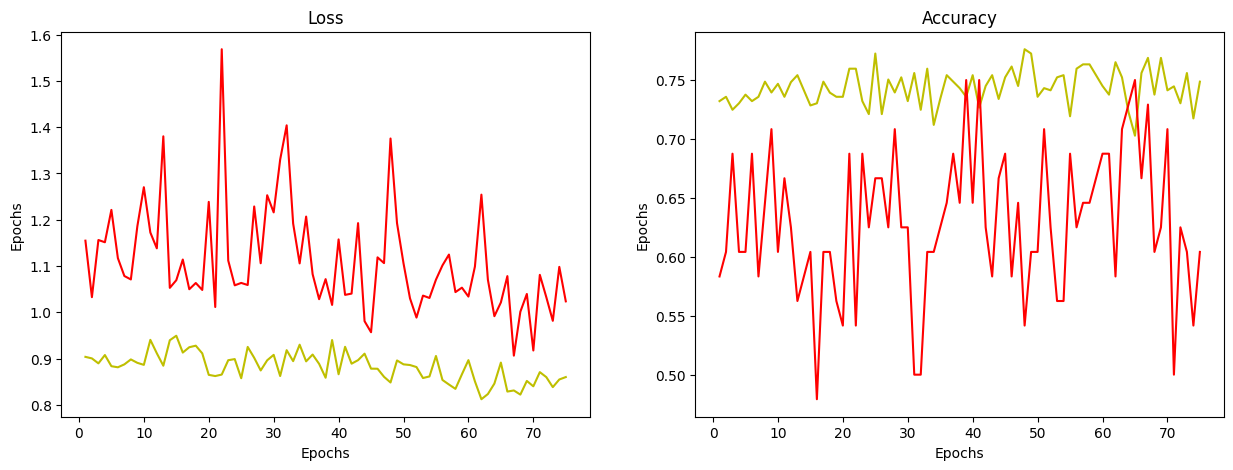

In [28]:
#loss curve
fig, axs=plt.subplots(ncols=2,figsize=(15, 5))#, figsize=(20,20))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set(title='Loss', xlabel='Epochs', ylabel='Epochs');

#accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
axs[1].plot(epochs, acc, 'y', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Epochs');

In [ ]:
"""
Resnet50V2
with no conv2d and with dropout 77
with conv2d 85
with conv2d and with dropout
with regularization
"""

In [ ]:
model.save('VGG+conv2d(600).h5')
#continue_model=load_model('to_continue.h5')

## Evaluating Model

In [21]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
new_model=load_model("/root/DR-detection-using-OCT-A/saved_models/Resnet50v2+conv2D_0.85_06.hdf5")
new2_model=load_model("/root/DR-detection-using-OCT-A/saved_models/Resnet50v2+conv2D_0.77_19.hdf5")

/tmp/ipykernel_11415/4225849823.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results=model_eval.evaluate_generator(data_eval, steps=len(data_eval.classes)//batch_size)
2023-04-12 15:53:18.675073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Loss and accuracy are [0.8861393928527832, 0.7910714149475098]


/tmp/ipykernel_11415/4225849823.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_eval.predict_generator(data_eval, steps=len(data_eval.classes)//batch_size+1)
2023-04-12 15:53:26.151880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Confusion Matrix


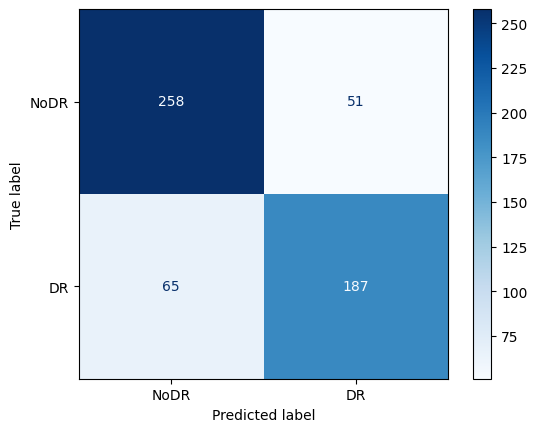

Classification Report
              precision    recall  f1-score   support

        NoDR       0.80      0.83      0.82       309
          DR       0.79      0.74      0.76       252

    accuracy                           0.79       561
   macro avg       0.79      0.79      0.79       561
weighted avg       0.79      0.79      0.79       561



In [25]:
data_eval=train_generator_validation
model_eval=model
results=model_eval.evaluate_generator(data_eval, steps=len(data_eval.classes)//batch_size)
print("Loss and accuracy are", results)
Y_pred = model_eval.predict_generator(data_eval, steps=len(data_eval.classes)//batch_size+1)
#print(train_generator.classes)
y_pred = np.argmax(Y_pred, axis=1)
#print(train_generator.classes)
#print(y_pred)
#print(X)
        
print('Confusion Matrix')
cm=confusion_matrix(data_eval.classes,y_pred)
target_names = ['NoDR', 'DR']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')

print(classification_report(data_eval.classes,y_pred, target_names=target_names))